## Team Patrick AFK
- Gabriela Putri Jelita Sihutomo 0706012210048 
- Patrick Steven Kent Sugiarto 0706012210046 
- Dave Nathaniel Yoseph 0706012110042 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)
from sklearn.metrics import confusion_matrix
import pickle

## Load the Dataset

In [2]:
# Load dataset
url = 'water_potability.csv'
try:
    df = pd.read_csv(url)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'water_potability.csv' was not found.")
    raise

Dataset loaded successfully.


## Data Exploration

In [3]:
print("\nDataset info:")
print(df.info())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB
None


In [4]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


## Data Visualization

[]

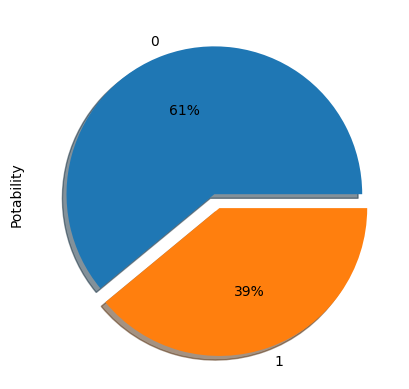

In [5]:
df['Potability'].value_counts().plot.pie(explode=(0,0.1),autopct="%.0f%%",shadow=True)
plt.plot()

Data distribution

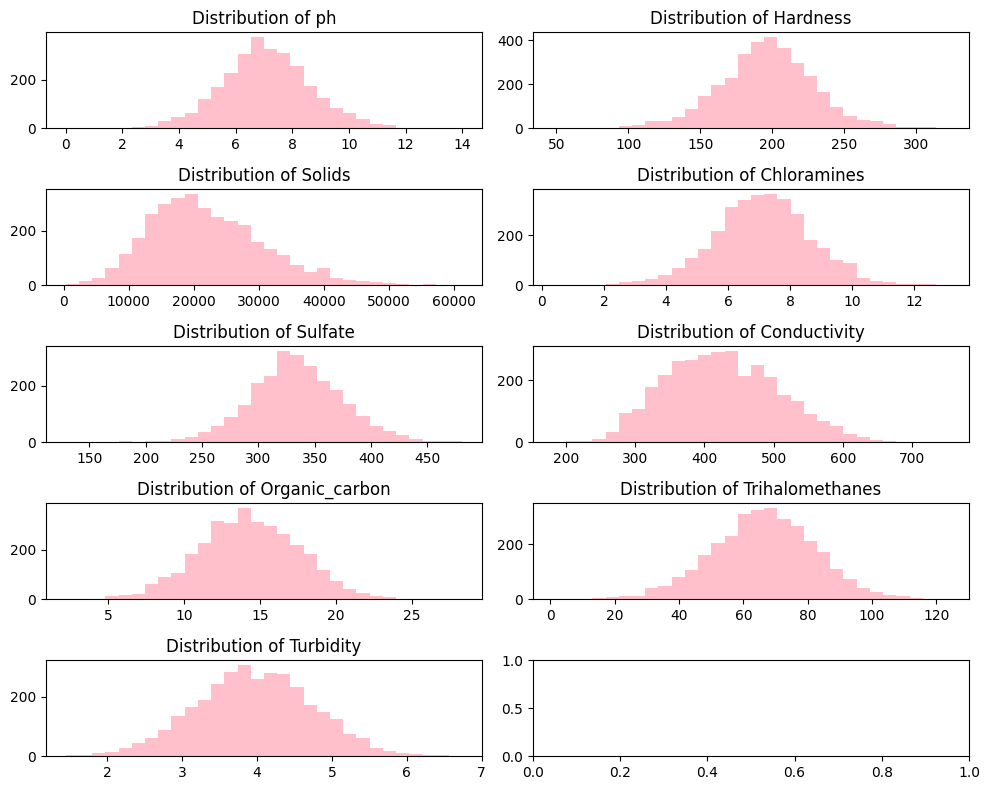

In [6]:
float_cols = df.select_dtypes('float64').columns
fig, axes = plt.subplots(len(float_cols)//2 + len(float_cols)%2, 2, figsize=(10, 8))
axes = axes.flatten()

for idx, col in enumerate(float_cols):
    axes[idx].hist(df[col], bins=30, color='pink')
    axes[idx].set_title(f'Distribution of {col}')
    
plt.tight_layout()
plt.show()

Check for Outliers

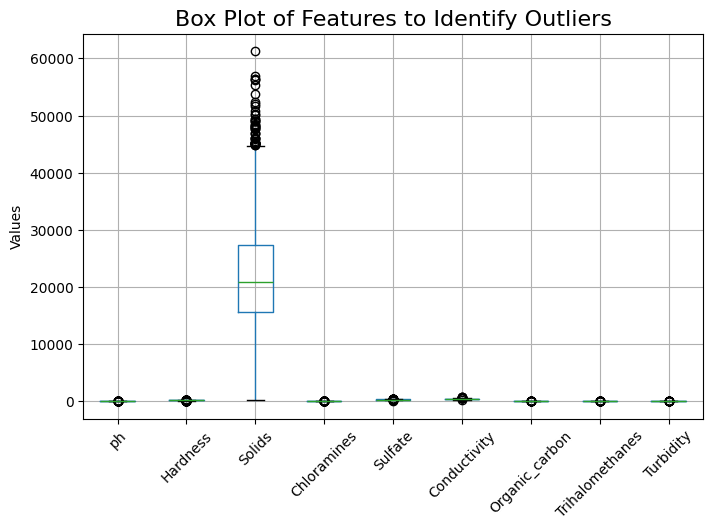

In [7]:
# create a box plot of total dissolved solids (solids) to identify outliers
plt.figure(figsize=(8, 5))
df.drop(['Potability'], axis=1).boxplot()
plt.title('Box Plot of Features to Identify Outliers', fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('Values')
plt.show()

## Data Preprocessing

1. Check and Handle Missing Values

In [8]:
df.columns = df.columns.str.strip()

print("\nMissing values:")
print(df.isnull().sum().sort_values(ascending=False))


Missing values:
Sulfate            781
ph                 491
Trihalomethanes    162
Hardness             0
Solids               0
Chloramines          0
Conductivity         0
Organic_carbon       0
Turbidity            0
Potability           0
dtype: int64


In [9]:
# # Menghitung Q1 dan Q3 untuk setiap kolom
# Q1 = df.quantile(0.25)
# Q3 = df.quantile(0.75)
# IQR = Q3 - Q1

# # Menentukan batas bawah dan atas
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Identifikasi outliers
# outliers = ((df < lower_bound) | (df > upper_bound))

# # Ganti outliers dengan median kolom
# for column in df.columns:
#     if outliers[column].any():  # Cek jika ada outlier di kolom ini
#         median_value = df[column].mean()  # Hitung median
#         df[column] = df[column].mask(outliers[column], median_value)  # Ganti outlier dengan median

# # Tampilkan DataFrame setelah penggantian outlier
# print("Data setelah mengganti outliers:")
# print(df.head())

In [10]:
# Filling null values in Sulfate column with mode 
df['Sulfate'] = df['Sulfate'].fillna(df['Sulfate'].mean())  
# Filling null values in ph column with it's mean 
df['ph'] = df['ph'].fillna(df['ph'].mean())                 
# Filling null values in Trihalomethanes column with mode
df['Trihalomethanes'] = df['Trihalomethanes'].fillna(df['Trihalomethanes'].mean())

In [11]:
# Displaying values after filling
df.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [12]:
print("\Data distribution in 'Potability':")
print(df['Potability'].value_counts())

\Data distribution in 'Potability':
0    1998
1    1278
Name: Potability, dtype: int64


In [13]:
features = df.drop(['Potability'], axis=1)
# features = df[['ph', 'Solids', 'Chloramines', 'Hardness', 'Sulfate', 'Trihalomethanes']]
target = df['Potability']

2. Balancing data imbalance using SMOTE


Class distribution after SMOTE:
0    1998
1    1998
Name: Potability, dtype: int64


[]

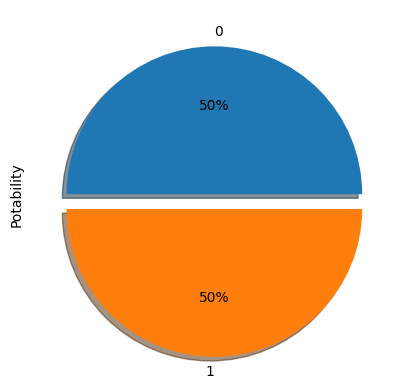

In [14]:
smote = SMOTE(random_state=42)
features_resampled, target_resampled = smote.fit_resample(features, target)
print("\nClass distribution after SMOTE:")
print(pd.Series(target_resampled).value_counts())
target_resampled.value_counts().plot.pie(explode=(0,0.1),autopct="%.0f%%",shadow=True)
plt.plot()


3. Data splitting

In [15]:
# x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
x_train, x_test, y_train, y_test = train_test_split(features_resampled, target_resampled, test_size=0.2, random_state=42, stratify=target_resampled)

4. Data scaling using RobustScaler

In [16]:
scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# # Save the scaler
# scaler_filename = 'robust_scaler.pkl'
# with open(scaler_filename, 'wb') as file:
#     pickle.dump(scaler, file)

# print(f"Scaler saved to {scaler_filename}.")

## Model Creation

1. Initialize models

In [17]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ),
    "SVM": SVC(probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000)
}

2. Tuning the hyperparameters

In [18]:
param_grids = {
    "Random Forest": {
    'n_estimators': [100, 200, 300],  # Jumlah pohon dalam hutan
    'max_depth': [None, 5, 10, 15],   # Kedalaman maksimum pohon
    'min_samples_split': [2, 5, 10],  # Minimum sampel untuk membagi simpul
    'min_samples_leaf': [1, 2, 4],    # Minimum sampel di simpul daun
    'max_features': ['auto', 'sqrt', 'log2']  # Fitur maksimum untuk dipertimbangkan
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
    },
    "Logistic Regression": {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced']
    }
}

results_list = []

3. Train and evaluate each model with classification report and confusion matrix


Model: Random Forest
Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\daven\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
200 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
87 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\daven\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\daven\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\daven\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.

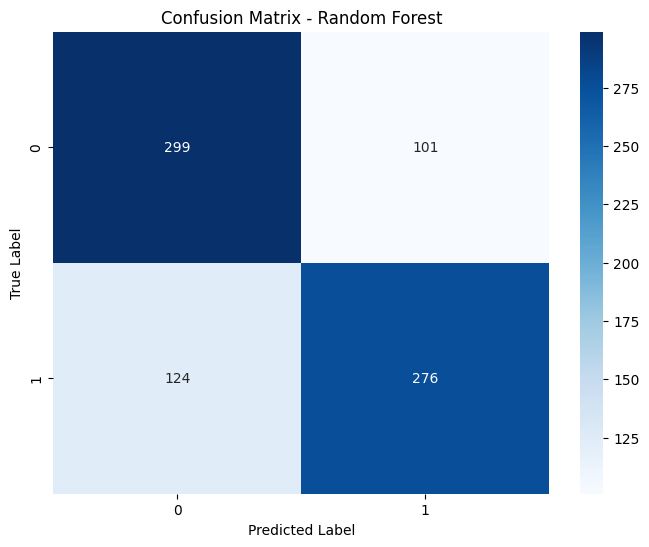

Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best CV Score: 0.7043

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       400
           1       0.73      0.69      0.71       400

    accuracy                           0.72       800
   macro avg       0.72      0.72      0.72       800
weighted avg       0.72      0.72      0.72       800


Confusion Matrix:
[[299 101]
 [124 276]]

Model: XGBoost
Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\daven\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


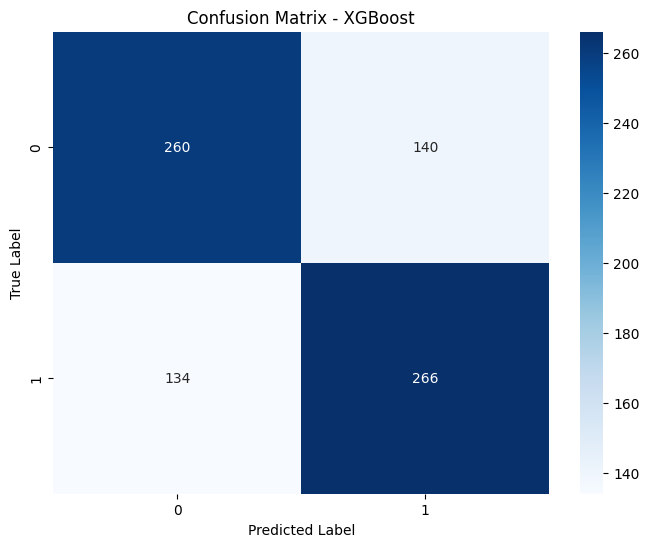

Best Parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2}
Best CV Score: 0.6733

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.66      0.67      0.66       400

    accuracy                           0.66       800
   macro avg       0.66      0.66      0.66       800
weighted avg       0.66      0.66      0.66       800


Confusion Matrix:
[[260 140]
 [134 266]]

Model: SVM
Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\daven\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


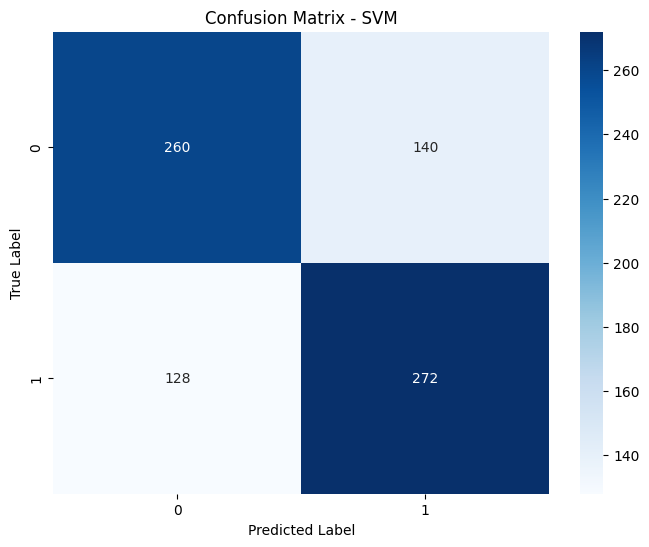

Best Parameters: {'kernel': 'rbf', 'C': 10}
Best CV Score: 0.6718

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       400
           1       0.66      0.68      0.67       400

    accuracy                           0.67       800
   macro avg       0.67      0.67      0.66       800
weighted avg       0.67      0.67      0.66       800


Confusion Matrix:
[[260 140]
 [128 272]]

Model: Logistic Regression
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\daven\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


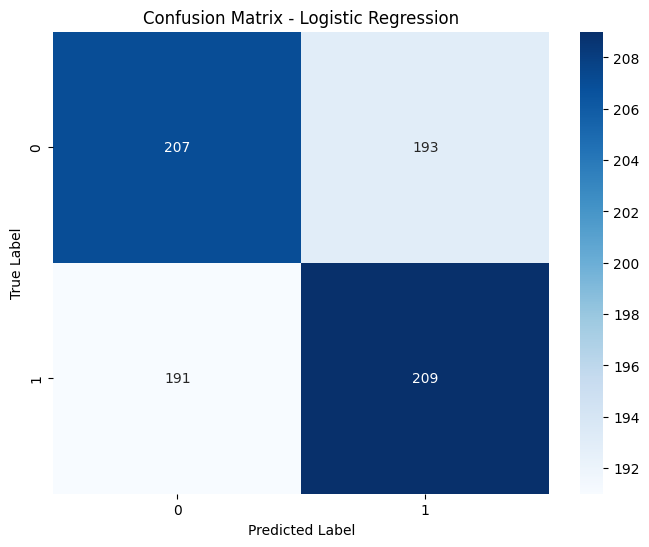

Best Parameters: {'solver': 'saga', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.01}
Best CV Score: 0.5072

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52       400
           1       0.52      0.52      0.52       400

    accuracy                           0.52       800
   macro avg       0.52      0.52      0.52       800
weighted avg       0.52      0.52      0.52       800


Confusion Matrix:
[[207 193]
 [191 209]]


In [19]:
model_metrics = {}


for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Model: {name}")
    print('='*50)
    
    try:
        # # GridSearch
        # grid_search = GridSearchCV(
        #     model, 
        #     param_grids[name], 
        #     cv=3, 
        #     scoring='accuracy', 
        #     n_jobs=-1,
        #     verbose=1
        # )
        # grid_search.fit(x_train_scaled, y_train)

        # Menggunakan RandomizedSearchCV
        random_search = RandomizedSearchCV(
            model,
            param_grids[name],
            n_iter=100,
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1,
            random_state=42
        )

        # Fit model
        random_search.fit(x_train_scaled, y_train)
        
        # Best model
        best_model = random_search.best_estimator_
        y_pred = best_model.predict(x_test_scaled)

        # # Mendapatkan pentingnya fitur
        # importances = best_model.feature_importances_

        # # Buat DataFrame untuk menyimpan hasil pentingnya fitur
        # feature_importance_df = pd.DataFrame({
        #     'Feature': features.columns,
        #     'Importance': importances
        # })

        # # Urutkan berdasarkan pentingnya fitur
        # feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        # # Tampilkan hasil pentingnya fitur
        # print(feature_importance_df)

        # # Visualisasi pentingnya fitur
        # plt.figure(figsize=(10, 6))
        # sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
        # plt.title('Feature Importance')
        # plt.xlabel('Importance')
        # plt.ylabel('Feature')
        # plt.show()
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Store metrics
        model_metrics[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'model': best_model,
            'parameters': random_search.best_params_,
            'cv_score': random_search.best_score_,
            'confusion_matrix': cm
        }
        
        # Print results
        print(f"Best Parameters: {random_search.best_params_}")
        print(f"Best CV Score: {random_search.best_score_:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print("\nConfusion Matrix:")
        print(cm)
        
    except Exception as e:
        print(f"Error occurred while tuning {name}: {e}")

In [20]:
# # Save the best model
# model_filename = 'best_model.pkl'
# with open(model_filename, 'wb') as file:
#     pickle.dump(best_model, file)

# print(f"Model saved to {model_filename}.")